# Housing Example

## Download the data

In [76]:
import os
import tarfile
from six.moves import urllib

In [77]:
# Data source
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [78]:
# Make the function to fetech the data automatically
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [79]:
fetch_housing_data()

## Take a quick look

In [80]:
import pandas as pd

In [81]:
# Define the function to read the csv data
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [82]:
# Inspect the data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [83]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [84]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


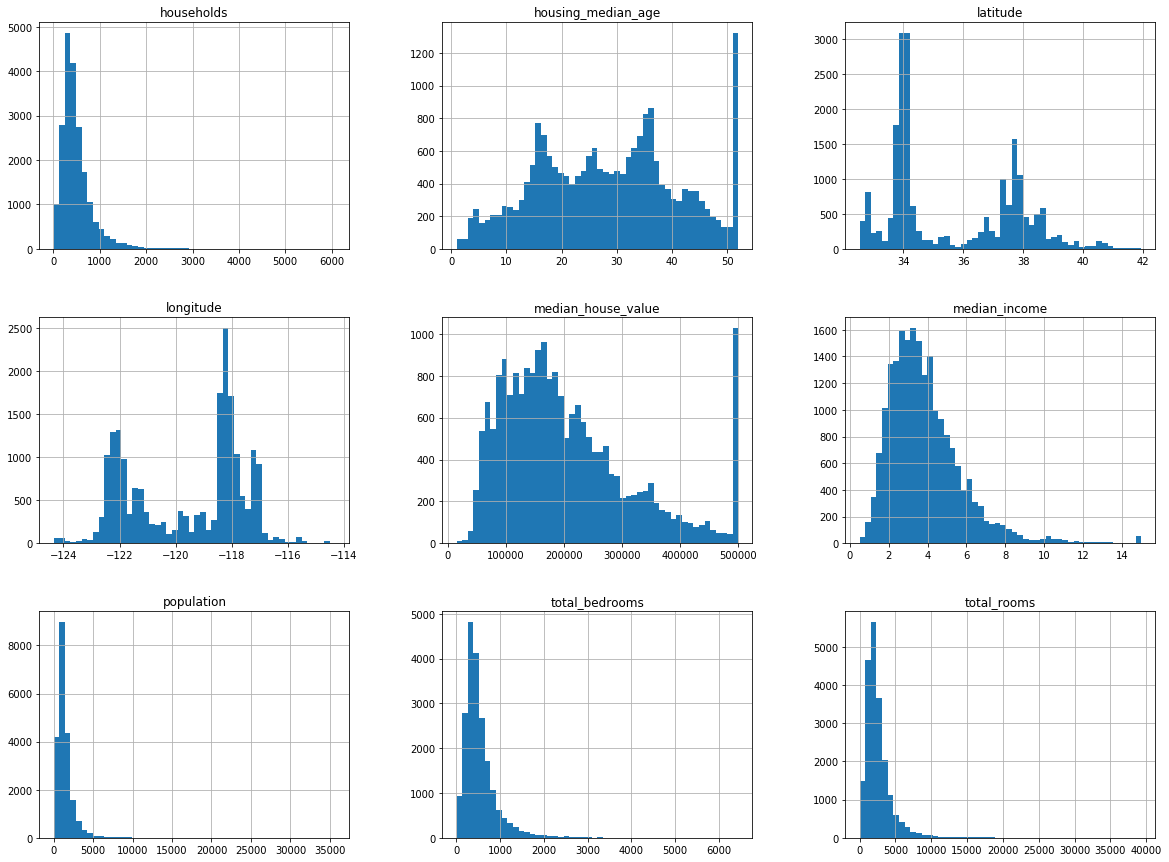

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Problems here:  

1. The median income is preprocessed, which should be multiplied with 10,000. It is also capped at 15.
2. The housing median age and the median house value were capped.
3. All of the attributes have different scale
4. Many of them are tail heavy

## Create a test set

In [86]:
import numpy as np

In [87]:
# One way of split the train test set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [88]:
train_set, test_set = split_train_test(housing, 0.2)

In [89]:
len(train_set)

16512

In [90]:
len(test_set)

4128

Not perfect: will generate a different test set on the next run.  

Possible solutions:  

1. Run and save them as different datasets
2. Use np.random.seed(n), n can be any number  

However, according to the book, these solutions will break next time when fetching an updated dataset, so we can use each instance's identifier to decide whether or not it should go into the dataset, and the following function is the implementation.

In [91]:
from zlib import crc32

In [92]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2*32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [93]:
# One way of setting the id column for the dataset, 
# but need to assume the row order cannot be moved
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [94]:
# Another way that does not need the assumption
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [95]:
# Use the way that provided by sklearn
from sklearn.model_selection import train_test_split

In [96]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [97]:
# In order to do stratified sample, first split the median_income into 5 categories
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3, 4.5, 6, np.inf], 
      labels = [1, 2, 3, 4, 5])

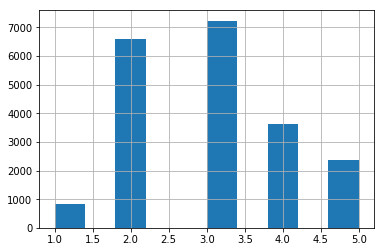

In [98]:
housing["income_cat"].hist()
plt.show()

In [99]:
from sklearn.model_selection import StratifiedShuffleSplit

In [100]:
# Do the stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"].astype(int)):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [101]:
# Compare the ratio of each group in the dataset and they are found to be similar
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [102]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [103]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Explore and visualize the data

In [104]:
housing = strat_train_set.copy()

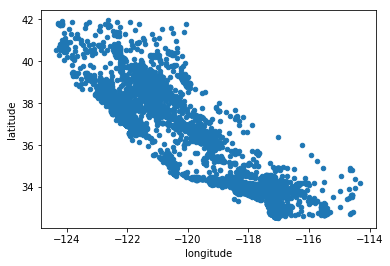

In [105]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

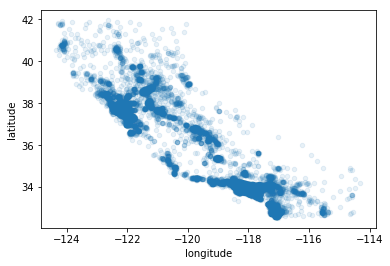

In [106]:
# Set the alpha to visualize the density of data
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

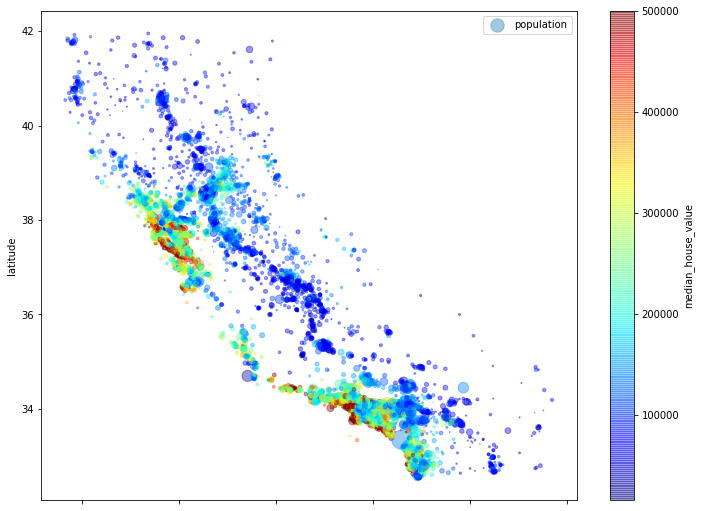

In [107]:
# Use the size of scatter points to represent the population 
# and use color to represent the median house value
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', c='median_house_value',
            cmap=plt.get_cmap('jet'), colorbar=True, figsize=(12,9))
plt.legend()
plt.show()

This suggests that the housing prices are very much related to the location. It might be useful to use a clustering algorithm to detect the main cluster and add new features athat measure the proximity to the cluster centers.

In [108]:
corr_matrix = housing.corr()

In [109]:
# Try visualizing the correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1,-0.92,-0.11,0.049,0.077,0.11,0.063,-0.02,-0.047
latitude,-0.92,1,0.0058,-0.039,-0.072,-0.12,-0.078,-0.075,-0.14
housing_median_age,-0.11,0.0058,1,-0.36,-0.33,-0.3,-0.31,-0.11,0.11
total_rooms,0.049,-0.039,-0.36,1,0.93,0.86,0.92,0.2,0.14
total_bedrooms,0.077,-0.072,-0.33,0.93,1,0.88,0.98,-0.0097,0.048
population,0.11,-0.12,-0.3,0.86,0.88,1,0.9,0.0024,-0.027
households,0.063,-0.078,-0.31,0.92,0.98,0.9,1,0.011,0.065
median_income,-0.02,-0.075,-0.11,0.2,-0.0097,0.0024,0.011,1,0.69
median_house_value,-0.047,-0.14,0.11,0.14,0.048,-0.027,0.065,0.69,1


In [110]:
# See which attributes are correlated with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [111]:
from pandas.plotting import scatter_matrix

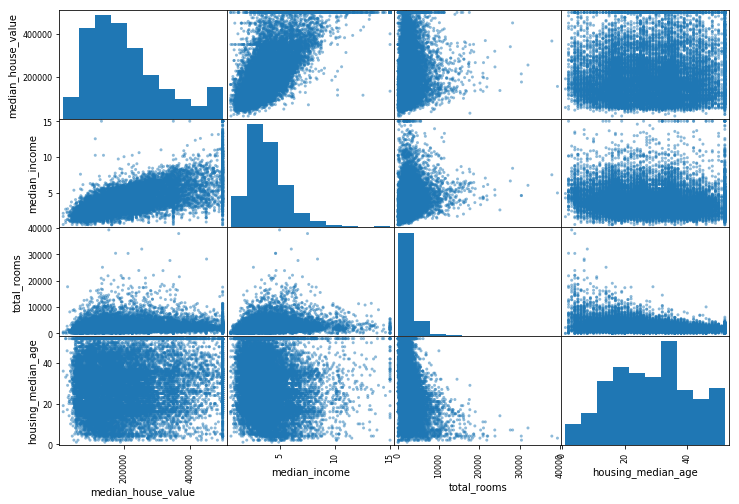

In [112]:
# Plot the scatter matrix using the most important attributes
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

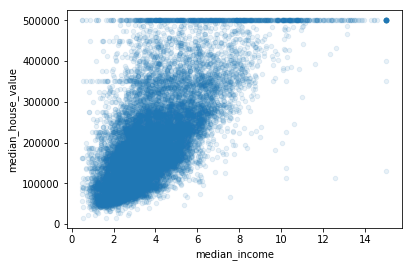

In [113]:
# Plot the most important one, median_income_value vs median_income
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

Two other lines at spotted around median house value of 35,000 and 45,000, which could hardly be seen using previous methods.

In [114]:
# Add 3 new attributes using the existing ones
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing ["bedrooms_per_room"] = housing ["total_bedrooms"] / housing ["total_rooms"]
housing ["population_per_household"] = housing ["population"] / housing ["households"] 

In [115]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Some good results shown in the correlation matrix, for example, the rooms_per_room has high correlatoin with the median_house_value.

## Prepare the data for ML

In [116]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

3 options to deal with the missing values in the total_bedrooms attribute:  

1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the values to some value (zero, the mean, the median, etc.)

If we are using the third option, we can use the impute function in sklearn.

In [117]:
from sklearn.impute import SimpleImputer

In [118]:
imputer = SimpleImputer(strategy='median')

# remove the text attribute ocean_proximity
housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

Look at the imputer statistics and compare with the medians

In [119]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [120]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [121]:
# Transform using the fitted imputer, and it results in a np array
X = imputer.transform(housing_num)

In [122]:
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [123]:
housing_cat = housing[['ocean_proximity']]

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [49]:
# can be converted to dense matrix by using the toarray() method
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [50]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [51]:
# Custom Transformation

from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedroom_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedroom_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [52]:
# Transformation pipelines

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [53]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [54]:
# Tranformation of numerical and categorical at the same time

from sklearn.compose import ColumnTransformer

In [55]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

## Select and train a model

In [56]:
from sklearn.linear_model import LinearRegression

In [57]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [58]:
# try with some data
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [59]:
# Take a look at the RMSE

from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
linrmse = np.sqrt(lin_mse)
linrmse

68628.19819848923

In [60]:
# Then try the decision tree model

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [61]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [62]:
# Use cross-validation to see the performance of the decision tree model

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [63]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [68729.11221524 66445.19776551 71018.52880389 68372.18195532
 70475.63752268 74444.88110184 70559.01776128 70541.33608111
 76593.91175406 69458.97605505]
Mean: 70663.87810159981
Standard deviation: 2790.9272592256793


In [64]:
# Use cross-validation to see the performance of the linear regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.6740017983493


It looks like the decision tree model is overfitting too much and the performance is not as good as the linear regression model.

In [65]:
# Then try the random forest model

from sklearn.ensemble import RandomForestRegressor

In [66]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22415.362363420667

In [67]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [52467.91413384 50028.95653221 53105.32431017 54701.42157048
 51904.41458599 55695.38233557 51982.39747318 51001.57564331
 55428.31894587 52107.89240353]
Mean: 52842.359793412805
Standard deviation: 1787.5915610898448


It looks like the random forest has a better performance, even though that on the validation set is still not as good as the training set.

## Fine-tune the model

In [68]:
from sklearn.model_selection import GridSearchCV

In [69]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [70]:
# See the best parameter setting
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [71]:
# See the best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [72]:
# See the score of each iteration
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64489.834466787746 {'max_features': 2, 'n_estimators': 3}
55499.72542475387 {'max_features': 2, 'n_estimators': 10}
52981.03252097048 {'max_features': 2, 'n_estimators': 30}
59349.748489506484 {'max_features': 4, 'n_estimators': 3}
52882.66210473577 {'max_features': 4, 'n_estimators': 10}
50870.46636249625 {'max_features': 4, 'n_estimators': 30}
58922.73744590239 {'max_features': 6, 'n_estimators': 3}
51693.61947634375 {'max_features': 6, 'n_estimators': 10}
49949.73218849596 {'max_features': 6, 'n_estimators': 30}
59030.89370707092 {'max_features': 8, 'n_estimators': 3}
52012.433280118734 {'max_features': 8, 'n_estimators': 10}
50106.493556229696 {'max_features': 8, 'n_estimators': 30}
62822.68580680131 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54063.025277887784 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59804.2731562528 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53048.3480872749 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [73]:
# See the importance of each feature
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.40427376e-02, 6.97596425e-02, 4.25612891e-02, 1.67726729e-02,
       1.73859935e-02, 1.84940877e-02, 1.65720367e-02, 3.21774193e-01,
       6.53574560e-02, 1.08692688e-01, 8.30923526e-02, 1.15337169e-02,
       1.44547386e-01, 5.74331851e-05, 3.65001167e-03, 5.70630291e-03])

In [74]:
extra_attribs = ['rooms_perhhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32177419329824064, 'median_income'),
 (0.14454738567246178, 'INLAND'),
 (0.10869268755706613, 'pop_per_hhold'),
 (0.08309235263611157, 'bedrooms_per_room'),
 (0.07404273763874276, 'longitude'),
 (0.06975964248742383, 'latitude'),
 (0.06535745602947146, 'rooms_perhhold'),
 (0.04256128914771391, 'housing_median_age'),
 (0.0184940877225606, 'population'),
 (0.017385993516867645, 'total_bedrooms'),
 (0.016772672945427097, 'total_rooms'),
 (0.016572036687253884, 'households'),
 (0.011533716900484433, '<1H OCEAN'),
 (0.005706302907993003, 'NEAR OCEAN'),
 (0.003650011667097274, 'NEAR BAY'),
 (5.743318508392805e-05, 'ISLAND')]

In [75]:
# Finally fit evaluate on the test set

final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47850.78834918051